In [1]:
from pathlib import Path

import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.mask
import scipy.stats 
import fiona

In [2]:
nan_val = -99999
grid_path = Path(r"D:\luke\Aus_magmap_v7_80m\Total Magnetic Intensity grid of Australia 2019 80m.ers")
shp_path = Path(r"D:\luke\Aus_magmap_v7_80m\mainland.shp")

with fiona.open(shp_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(grid_path) as src:
    grid, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": grid.shape[1],
                 "width": grid.shape[2],
                 "transform": out_transform})

# og_shape = grid.shape
# grid = grid.flatten()
grid[grid == nan_val] = np.nan

In [3]:
# # plt.subplot(2,1,1)
# # plt.title("Hist pre-null2nan")
# # plt.hist(grid.flatten(), bins=2000, density=True)
# # plt.xlim([-1000, 1000])
# # # plt.ylim([0, 3e8])

# plt.subplot(2,1,2)
# plt.title("Hist post-null2nan")
# plt.hist(grid.flatten(), bins=2000, density=True)
# plt.xlim([-1000, 1000])
# # plt.ylim([0, 3e8])

In [4]:
grid = grid[0]
# plt.imshow(grid, vmin=-500, vmax=500)

In [5]:
# from fitter import Fitter, get_common_distributions, get_distributions

# f = Fitter(
#     grid.flatten(),
#     xmin=np.nanmin(grid),
#     xmax=np.nanmax(grid),
#     timeout=60*60,
#     distributions=["laplace"],
#     )
# f.fit(progress=True)

# plt.figure(figsize=(15,15))
# f.summary(Nbest=5)

# fit = f.get_best(method="sumsquare_error")
# print("\n",fit)

In [6]:
# loc, scale = scipy.stats.laplace.fit(grid[~np.isnan(grid)], method="MLE")
loc, scale = scipy.stats.laplace.fit(grid[~np.isnan(grid)], method="MLE")
print(f"{loc = }, {scale = }")

loc = -88.5312, scale = 132.36258355616474


In [7]:
# x = 5000
# xlim=[-2e3, 2e3]

# lv = scipy.stats.laplace(loc=loc, scale=scale)
# l = np.linspace(lv.ppf(1e-16), lv.ppf(1 - 1e-16), x)

# rv = scipy.stats.norm()
# r = np.linspace(rv.ppf(1e-10), rv.ppf(1 - 1e-10), x)

# fig, [ax0, ax1, ax2] = plt.subplots(3, 1, figsize=(10,15))

# ax0.hist(grid.flatten(), bins=x, density=True, histtype='stepfilled', alpha=0.8, label="Density Histogram TMI")
# ax0.plot(l, lv.pdf(l), 'k-', lw=2, label='Fit Laplace PDF', alpha=0.7)
# ax0.legend(loc='best', frameon=False)
# ax0.set_title("Onshore Australia 80 m TMI PDF")
# ax0.set_xlim(xlim)
# # ax0.set_ylim([0, 1e-3])
# # plt.yscale("log")
# # ax0.text(-1500, 0.004, f"{loc=}\n{scale=}")

# ax1.plot(l, lv.cdf(l), 'r--', lw=2, label='Laplace CDF', alpha=0.7)
# ax1.legend(loc='best', frameon=False)
# ax1.set_xlim([-2e3, 2e3])
# ax1.set_title("Onshore Australia 80 m TMI CDF")

# ax2.plot(r, rv.cdf(r), label="Normal CDF")
# ax2.legend(loc='best', frameon=False)
# # ax2.set_xlim()

# plt.savefig("Onshore Australia Dists.png")
# plt.show()

In [8]:
def norm(arr, loc=-88.5, scale=132.4):
    """ Standardise input data (with Laplace distibution) to a Standard Gaussian distribution

    # Rounded loc/scale: WA_80m_Mag_Merge_v1_2020 , J.Brett GSWA, .
    Australian 80m TMI (continental) fit laplace: loc=-88.5, scale=132.4
    """

    import scipy.stats

    lv = scipy.stats.laplace(loc=loc, scale=scale)
    rv = scipy.stats.norm(loc=0.0, scale=1.0) # "Standard" Norm

    return rv.ppf(lv.cdf(arr))

In [9]:
# "MLE"
# print(f"{lv.cdf(-10000):.60g}")
# print(f"{lv.cdf(loc):.60g}")
# print(f"{lv.cdf(4500):.60g}")
# print(f"{lv.cdf(4800):.60g}")

# # "MM"
# # print(f"{lv.cdf(-100000):.60g}")
# # print(f"{lv.cdf(loc):.60g}")
# # print(f"{lv.cdf(7764):.60g}")
# # print(f"{lv.cdf(7765):.60g}")


In [10]:
norm_grid = norm(grid, loc=loc, scale=scale)

In [11]:
print(norm_grid[np.isfinite(norm_grid)].min())
print(norm_grid[np.isfinite(norm_grid)].max())
norm_grid[np.isneginf(norm_grid)] = norm_grid[np.isfinite(norm_grid)].min()
norm_grid[np.isposinf(norm_grid)] = norm_grid[np.isfinite(norm_grid)].max()

-23.841522229192346
8.209536151601387


In [12]:
print(norm_grid.min())
print(norm_grid.max())
print(np.nanmin(norm_grid))
print(np.nanmax(norm_grid))

nan
nan
-23.841522229192346
8.209536151601387


In [13]:
out_meta
norm_grid[np.isnan(norm_grid)] = nan_val

In [14]:
with rasterio.open("Normalised Australian 80 m TMI.tif", "w", **out_meta) as dest:
    dest.write(np.expand_dims(norm_grid, 0))

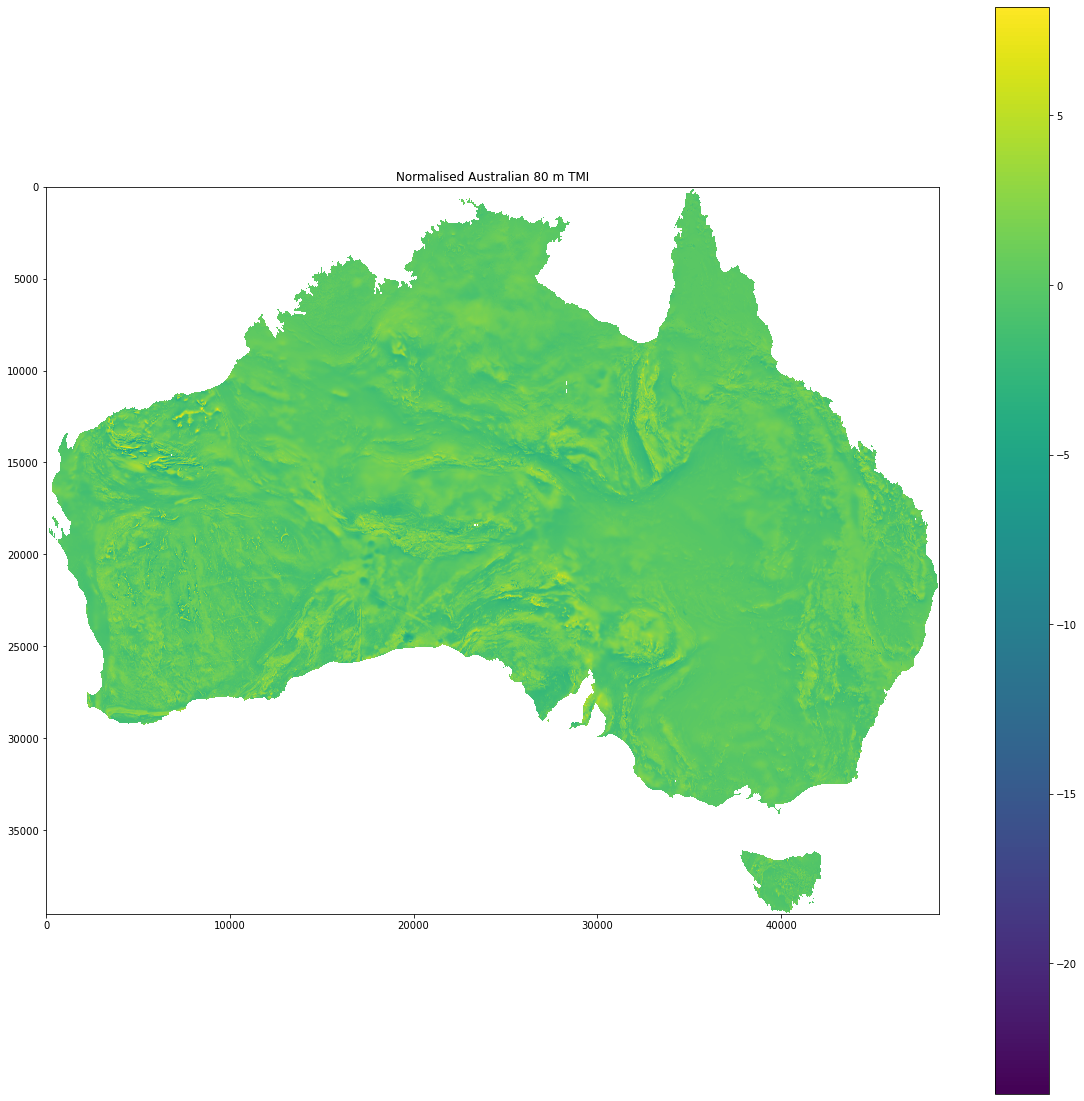

In [16]:
norm_grid[norm_grid == nan_val] = np.nan
plt.figure(figsize=(20,20))
plt.imshow(norm_grid)
plt.colorbar()
plt.title("Normalised Australian 80 m TMI")
plt.savefig("Normalised Australian 80 m TMI.png")

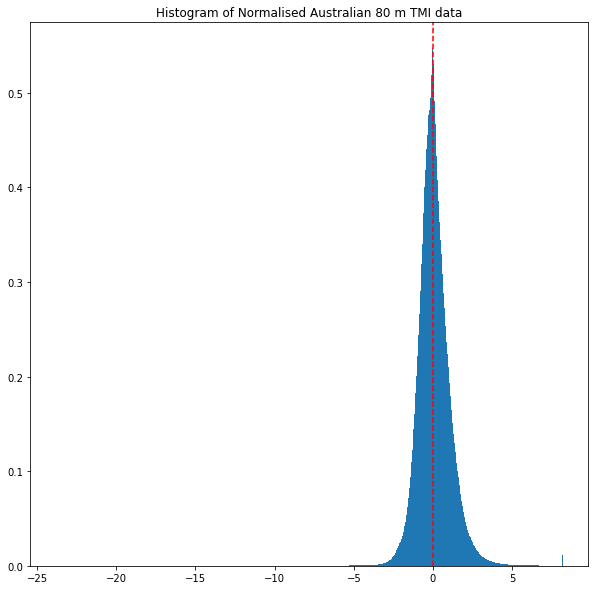

In [22]:
plt.figure(figsize=(10,10))
plt.title("Histogram of Normalised Australian 80 m TMI data")
plt.hist(norm_grid.flatten(), density=True, bins=1000)
plt.axvline(0, c='r', ls='--')